4.1 Есть данные за первые два дня прохождения курса по каждому студенту.  
Будем считать, что студент успешно закончит курс (т. е. не уйдет с него, passed_course = 1, is_gone = 0), если он наберет на нем 40 баллов.  
Задача: предсказать, закончит ли студент курс успешно (passed_course = 1, is_gone = 0) или уйдет с него (passed_course = 0, is_gone = 1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

Данные за все дни (на них будем обучать модель) - предобработка

In [3]:
events_data = pd.read_csv('event_data_train.csv')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
events_data['date'] = pd.to_datetime(events_data['timestamp'], unit='s')
events_data['day'] = events_data['date'].dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Отберем наблюдения за первые два дня

In [5]:
user_time = events_data.groupby('user_id', as_index=False).agg(
    {'timestamp' : 'min'}).rename({'timestamp' : 'min_timestamp'}, axis=1)
time_threshold = 3 * 24 * 60 * 60
user_time['user_time_threshold'] = user_time['min_timestamp'] + time_threshold

In [6]:
events_data = events_data.merge(user_time, how='outer', on='user_id')
events_data.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,1434600048


Исключаем наблюдения, где последняя активность была раньше полутора суток до конца рассматриваемого промежутка в два дня

In [7]:
events_data_train = events_data[events_data['timestamp'] <= events_data['user_time_threshold']]

In [72]:
actions_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', aggfunc='count', 
                        fill_value=0).reset_index()
actions_data['passed_course'] = actions_data['passed'] >= 40
actions_data.head()

action,user_id,discovered,passed,started_attempt,viewed,passed_course
0,1,1,0,0,1,False
1,2,9,9,2,10,False
2,3,91,87,30,192,True
3,5,11,11,4,12,False
4,7,1,1,0,1,False


In [73]:
actions_data_train = events_data_train.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', aggfunc='count', 
                        fill_value=0).reset_index()
actions_data_train = actions_data_train.merge(actions_data[['passed_course', 'user_id']], how='outer', on='user_id')
actions_data_train.head()

action,user_id,discovered,passed,started_attempt,viewed,passed_course
0,1,1,0,0,1,False
1,2,9,9,2,9,False
2,3,15,15,4,20,True
3,5,1,1,0,1,False
4,7,1,1,0,1,False


In [10]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [11]:
submissions_data['date'] = pd.to_datetime(submissions_data['timestamp'], unit='s')
submissions_data['day'] = submissions_data['date'].dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [12]:
submissions_data = submissions_data.merge(user_time, how='outer', on='user_id')
submissions_data_train = submissions_data[submissions_data['timestamp'] <= submissions_data['user_time_threshold']]
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp,user_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977,1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977,1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977,1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977,1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977,1434605177


In [74]:
X = submissions_data_train.groupby(
    'user_id')['day'].nunique().to_frame().reset_index().rename(columns={'day' : 'days'})

steps_tried = submissions_data_train.groupby('user_id')['step_id'].nunique().to_frame().reset_index().rename(
    columns={'step_id' : 'steps_tried'})
X = X.merge(steps_tried, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [14]:
scores_data_train = submissions_data_train.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', aggfunc='count', 
                        fill_value=0).reset_index()
scores_data_train['correct_ratio'] = scores_data_train['correct'] / (scores_data_train['correct'] + scores_data_train['wrong'])
scores_data_train.head()

submission_status,user_id,correct,wrong,correct_ratio
0,2,2,0,1.00
1,3,4,4,0.50
2,8,9,21,0.30
3,14,0,1,0.00
4,16,23,27,0.46


In [75]:
X = X.merge(scores_data_train, on='user_id', how='outer')
X = X.merge(actions_data_train, on='user_id', how='outer')
X = X.fillna(0)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed,passed_course
0,2,1.0,2.0,2.0,0.0,1.00,9,9,2,9,False
1,3,1.0,4.0,4.0,4.0,0.50,15,15,4,20,True
2,8,1.0,11.0,9.0,21.0,0.30,109,84,37,154,True
3,14,1.0,1.0,0.0,1.0,0.00,4,3,1,9,False
4,16,3.0,23.0,23.0,27.0,0.46,55,55,26,132,True


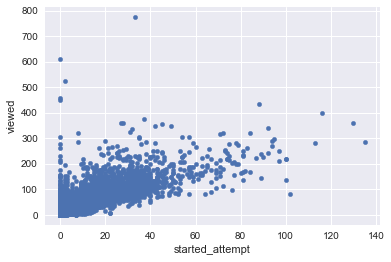

In [57]:
X.plot.scatter(x='started_attempt', y='viewed')

In [76]:
X = X.drop('wrong', axis=1)

In [77]:
X, y = X.drop('passed_course', axis=1), X['passed_course']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Обучение модели

In [83]:
rf = RandomForestClassifier()
grid_search_cv = GridSearchCV(rf, {'n_estimators' : range(30, 41, 2), 
                                   'max_depth' : range(4, 11, 2), 
                                   'min_samples_leaf' : range(150, 201, 25),
                                   'min_samples_split' : range(400, 501, 25)}, cv=5, n_jobs=-1)
%time grid_search_cv.fit(X_train, Y_train)

Wall time: 6min 46s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [85]:
best_rf = grid_search_cv.best_estimator_
Y_pred = best_rf.predict(X_test)
precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)

(0.8259668508287292, 0.5772200772200772)

In [86]:
grid_search_cv.best_params_

{'max_depth': 8,
 'min_samples_leaf': 175,
 'min_samples_split': 425,
 'n_estimators': 36}

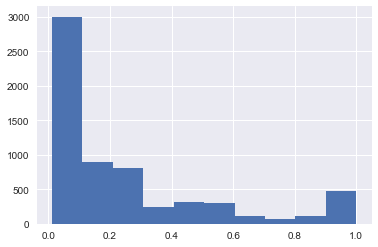

In [80]:
Y_pred_prob = best_rf.predict_proba(X_test)
pd.Series(Y_pred_prob[:,1]).hist()

In [87]:
Y_pred_tuned = np.where(Y_pred_prob[:, 1] > 0.4, 1, 0)
precision_score(Y_test, Y_pred_tuned), recall_score(Y_test, Y_pred_tuned)

(0.730305180979418, 0.6621621621621622)

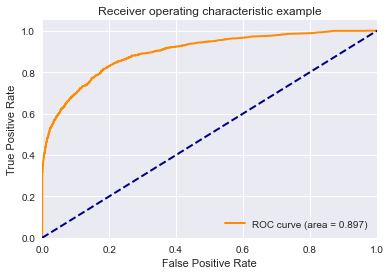

In [90]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob[:, 1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Данные за первые два дня (по ним надо предсказать) - предобработка

In [27]:
two_days_events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')
two_days_events_data.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [28]:
two_days_submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')
two_days_submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [5]:
two_days_events_data['user_id'].nunique()

6184

In [29]:
two_days_events_data['date'] = pd.to_datetime(two_days_events_data['timestamp'], unit='s')
two_days_events_data['day'] = two_days_events_data['date'].dt.date
two_days_events_data.head()

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


In [7]:
two_days_events_data.groupby('user_id')['day'].nunique().max()

3

In [30]:
two_days_submissions_data['date'] = pd.to_datetime(two_days_submissions_data['timestamp'], unit='s')
two_days_submissions_data['day'] = two_days_submissions_data['date'].dt.date
two_days_submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20


In [37]:
X_test = two_days_submissions_data.groupby(
    'user_id')['day'].nunique().to_frame().reset_index().rename(columns={'day' : 'days'})

two_days_steps_tried = two_days_submissions_data.groupby('user_id')['step_id'].nunique().to_frame().reset_index().rename(
    columns={'step_id' : 'steps_tried'})
X_test = X_test.merge(two_days_steps_tried, on='user_id', how='outer')
X_test.head()

,user_id,days,steps_tried
0,12,1,1
1,13,2,29
2,15,3,11
3,21,1,30
4,35,3,9


In [32]:
two_days_actions_data = two_days_events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', aggfunc='count', 
                        fill_value=0).reset_index()
two_days_actions_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


In [33]:
two_days_scores_data = two_days_submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', aggfunc='count', 
                        fill_value=0).reset_index()
two_days_scores_data['correct_ratio'] = two_days_scores_data['correct'] / (
    two_days_scores_data['correct'] + two_days_scores_data['wrong'])
two_days_scores_data.head()

submission_status,user_id,correct,wrong,correct_ratio
0,12,1,0,1.000000
1,13,29,36,0.446154
2,15,10,30,0.250000
3,21,24,103,0.188976
4,35,7,35,0.166667


In [38]:
X_test = X_test.merge(two_days_actions_data, on='user_id', how='outer')
X_test = X_test.merge(two_days_scores_data, on='user_id', how='outer')
X_test.head()

,user_id,days,steps_tried,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio
0,12,1.0,1.0,11,9,4,14,1.0,0.0,1.000000
1,13,2.0,29.0,70,70,35,105,29.0,36.0,0.446154
2,15,3.0,11.0,1,1,0,1,10.0,30.0,0.250000
3,21,1.0,30.0,74,68,70,98,24.0,103.0,0.188976
4,35,3.0,9.0,34,30,11,70,7.0,35.0,0.166667


In [39]:
X_test = X_test.drop('wrong', axis=1)

In [43]:
X_test = X_test.fillna(0)

ROC_AUC = 0.831

In [88]:
Y_pred = pd.DataFrame({'user_id' : X_test['user_id'],'is_gone' : best_rf.predict_proba(X_test)[:, 1]})
Y_pred.to_csv('ML_Stepik_contest_predictions.csv')

In [89]:
Y_pred.head()

,user_id,is_gone
200,595,0.234664
9760,2230,0.619992
2255,6590,0.304922
7066,21260,0.262680
10001,2841,0.041989


In [48]:
example = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_example.csv')
example.head()

,user_id,is_gone
0,12,0.26
1,13,0.79
2,15,0.12
3,21,0.67
4,35,0.62
